This code calculates the effect of topographic shading for user-input points on a glacier given by their latitude/longitude based on a DEM of the glacier's surrounding topography. This is output in two .csv files, one containing boolean data shaded yes/no, and the other containing potential clear-sky solar radiation.

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rioxarray as rxr
import xarray as xr
import pandas as pd
import suncalc
import geopandas as gpd
from pyproj import Transformer
from shapely.geometry import mapping
from numpy import pi, cos, sin, arctan

## INPUTS
Required:
- DEM, aspect and shading .tif files
- Lat/lon coordinates of the point of interest
- Local timezone of the point of interest

Optional:
- Angle step and length to determine the detail in the horizon search
- Plot? This is time-consuming but useful to visualize

In [130]:
# =================== INPUTS ===================
# model options
plot_horizon = True         # plot horizon search?
store_plot_horizon = True   # save .png horizon plot?
# ['sun_az','sun_elev','horizon_elev','shaded','dirirrslope','dirirr']
# plot_result = False         # plot results? False or list from ^
plot_result = ['sun_elev','dirirr','shaded','sun_az','dirirrslope','horizon_elev']
store_plot_result = True    # store .png result plot?
store_result = False        # store .csv output file?
angle_step = 5             # step to calculate horizon angle in degrees
search_length = 5000        # distance to search from center point (m)

# site information
timezone = pd.Timedelta(hours=-9)   # time zone of location
min_elev = 1200         # rough estimate of lower elevation bound of DEM
max_elev = 2000         # rough estimate of upper elevation bound of DEM
by = 'point'             # 'grid' or 'point' -- calculate single point or whole grid
if by == 'point':
    site = 'B'
    latlon_df = pd.read_csv('/home/claire/GulkanaDEM/gulkana_sites.csv',index_col=0)
    lat = latlon_df.loc[site]['lat']
    lon = latlon_df.loc[site]['lon']
    # lat = 63.260281         # latitude of point of interest
    # lon = -145.425720       # longitude of point of interest
    site_name = 'Gulkana' + site
elif by == 'grid':
    site_name = 'GulkanaGrid'

In [131]:
# =================== FILEPATHS ===================
fp = '/home/claire/research/'
# in: need DEM, slope and aspect
dem_fp = fp + '../GulkanaDEM/Gulkana_DEM_20m.tif'
aspect_fp = fp + '../GulkanaDEM/Gulkana_Aspect_20m.tif'
slope_fp = fp + '../GulkanaDEM/Gulkana_Slope_20m.tif'
# dem_fp = fp + '../GulkanaDEM/2m/Gulkana_2m_DEM.tif'
# aspect_fp = fp + '../GulkanaDEM/2m/Gulkana_2m_aspect.tif'
# slope_fp = fp + '../GulkanaDEM/2m/Gulkana_2m_slope.tif'
# optional shapefile
shp_fp = fp + '../GulkanaDEM/Gulkana.shp'

# out
out_fp = fp + '../GulkanaDEM/Out/gulkana_centerpoint.csv'
out_image_fp = fp + f'../GulkanaDEM/Outputs/{site_name}.png'
out_horizon_fp = fp + f'../GulkanaDEM/Outputs/{site_name}_horizon.png'

## PREPROCESS

In [132]:
# =================== SETUP ===================
# open files
dem = rxr.open_rasterio(dem_fp).isel(band=0)
aspect = rxr.open_rasterio(aspect_fp).isel(band=0)
slope = rxr.open_rasterio(slope_fp).isel(band=0)
dem_res = dem.rio.resolution()[0]

# ensure same coordinates
shapefile = gpd.read_file(shp_fp).set_crs(epsg=4326)
shapefile = shapefile.to_crs(dem.rio.crs)

# filter nans
dem = dem.where(dem > 0)
aspect = aspect.where(aspect > 0)
slope = slope.where(slope > 0)

if by == 'point':
    # get UTM coordinates from lat/lon
    transformer = Transformer.from_crs('EPSG:4326', dem.rio.crs, always_xy=True)
    xx, yy = transformer.transform(lon, lat)

# get elevation of point from grid
point_elev = dem.sel(x=xx, y=yy, method="nearest").values

# get slope and aspect at point of interest
asp = aspect.sel(x=xx, y=yy, method="nearest").values * pi/180
slp = slope.sel(x=xx, y=yy, method="nearest").values * pi/180

In [133]:
# =================== CONSTANTS ===================
I0 = 1368       # solar constant in W m-2
P0 = 101325     # sea-level pressure in Pa
PSI = 0.75      # vertical atmospheric clear-sky transmissivity
r_m = 1         # mean earth-sun radius in AU

## DEFINE FUNCTIONS
Includes functions to get sun position, air pressure, and sun-to-earth radius

In [134]:
# =================== FUNCTIONS ===================
def r_sun(time):
    """From DEBAM manual, gets earth-to-sun radius in AU"""
    doy = time.day_of_year
    # From DEBAM manual
    # theta = (2*pi*doy) / 365 * pi/180
    # radius = 1.000110 + 0.34221*cos(theta) + 1.280e-3*sin(theta) + 7.19e-4*cos(2*theta) + 7.7e-5*sin(2*theta)
    radius = 1 - 0.01672*cos(0.9856*(doy-4))
    return radius

def pressure(elev):
    """Adjusts air pressure by elevation"""
    P = np.exp(-0.0001184*elev)*P0
    return P

def zenith(time):
    """Calculates solar zenith angle for time, lat and lon"""
    time_UTC = time - timezone
    altitude_angle = suncalc.get_position(time_UTC,lon,lat)['altitude']
    zenith = pi/2 - altitude_angle if altitude_angle > 0 else np.nan
    return zenith

def declination(time):
    """Calculates solar declination"""
    doy = time.day_of_year
    delta = -23.4*cos(360*(doy+10)/365) * pi/180
    return delta

hour_angle = lambda t: 15*(12-t.day_of_year)

def select_coordinates(angle,step_size,length):
    """Creates a line of points from the starting cell
    to select grid cells in a given direction (angle in 
    deg 0-360 where 0 is North)"""
    # get starting coordinates
    start_x = xx
    start_y = yy

    # convert angle to radians and make 0 north
    rad = angle * pi/180 + pi/2

    # get change in x and y for each step
    dx = - step_size * cos(rad) # negative so it travels clockwise
    dy = step_size * sin(rad)

    # define end
    n_steps = np.ceil(length / step_size).astype(int)
    end_x = start_x + dx*n_steps
    end_y = start_y + dy*n_steps
    
    # create lines
    xs = np.linspace(start_x,end_x,n_steps)
    ys = np.linspace(start_y,end_y,n_steps)
    if xs.shape > ys.shape:
        ys = np.ones(n_steps) * start_y
    elif ys.shape > xs.shape:
        xs = np.ones(n_steps) * start_x
    
    return xs,ys

def find_horizon(elev,xs,ys,buffer = 30):
    """Finds the horizon along a line of elevation
    values paired to x,y coordinates
    - elev: array of elevations in a single direction
    - xs, ys: coordinates corresponding to elev
    - buffer: defines the minimum number of gridcells
                away the horizon can be found 
                (needed when looking uphill)"""
    # calculate distance from origin and height relative to origin
    distances = np.sqrt((xs-xx)**2+(ys-yy)**2)
    distances[np.where(distances < 1e-3)[0]] = 1e-6
    heights = elev - point_elev
    heights[np.where(heights < 0)[0]] = 0

    # identify maximum horizon elevation angle
    elev_angles = arctan(heights/distances)
    idx = np.argmax(elev_angles[buffer:]) + buffer

    # index out information about the horizon point
    horizon_angle = elev_angles[idx]
    # horizon_distance = distances[idx]
    # horizon_height = heights[idx]
    horizon_x = xs[idx]
    horizon_y = ys[idx]
    return horizon_angle,horizon_x,horizon_y,elev_angles

## VISUALIZE

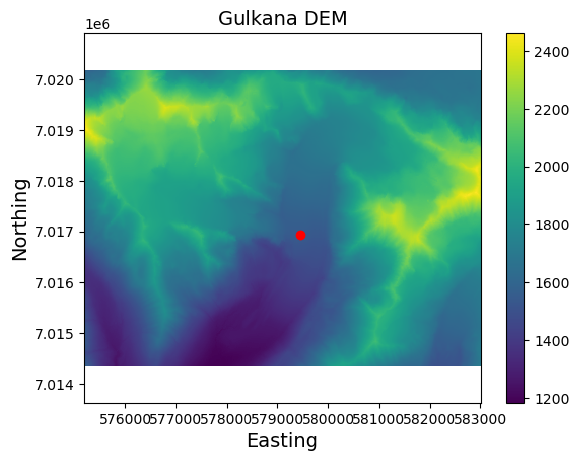

In [135]:
# PLOT DEM
if plot_horizon:
    dem.plot(cmap='viridis')
    plt.scatter(xx,yy,color='red')
    plt.axis('equal') 
    plt.title('Gulkana DEM',fontsize=14)
    plt.xlabel('Easting',fontsize=14)
    plt.ylabel('Northing',fontsize=14)
    plt.show()

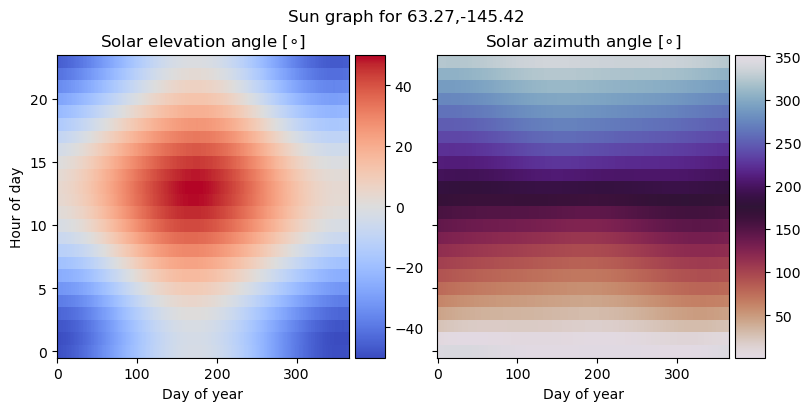

In [136]:
# PLOT SUN GRAPH FOR LAT/LON
all_hours = pd.date_range('2000-01-01 09:00','2001-01-01 08:00',freq='h')
days = np.arange(0,366)
hours = np.arange(0,24)
alt = np.array(suncalc.get_position(all_hours,lon,lat)['altitude'])
alt_reshape = alt.reshape((len(days),24)) * 180/pi
az = np.array(suncalc.get_position(all_hours,lon,lat)['azimuth']) + pi
az_reshape = az.reshape((len(days),24)) * 180/pi

fig,ax = plt.subplots(1,2,figsize=(8,4),layout='constrained',sharey=True)
pc = ax[0].pcolormesh(days,hours,alt_reshape.T, cmap='coolwarm')
fig.colorbar(pc,ax=ax[0],aspect=10,pad=0.02)
pc = ax[1].pcolormesh(days,hours,az_reshape.T, cmap='twilight_r')
fig.colorbar(pc,ax=ax[1],aspect=10,pad=0.02)
fig.suptitle(f'Sun graph for {lat:.2f},{lon:.2f}')
ax[0].set_xlabel('Day of year')
ax[1].set_xlabel('Day of year')
ax[0].set_title('Solar elevation angle [$\circ$]')
ax[1].set_title('Solar azimuth angle [$\circ$]')
ax[0].set_ylabel('Hour of day')
plt.show()

### Define function to select gridcells in a given direction from the point

pseudocode
- select a direction
- get array of coordinates that approximately lead that direction from the point of interest
- select those points from the DEM to get an array of elevations
- calculate the slope between the point of interest and each point in the elevation array
- that with the highest slope is the angle of the horizon
- repeat across a bunch of different azimuth angles and integrate or average to get sky view factor
    - in doing so create array of horizon angles for a bunch of different azimuth angles
- loop through time
    - check if solar elevation angle is above the elevation angle for the nearest
    - create array of SHADING (bool) DIRECT SLOPE-CORRECTED IRRADIANCE (float) values
    - export as .csv for a single point in space (x = hours of day, y = days of year)
    - include in exported .csv the sky-view factor (not time-dependent)
- check against something else somehow

TOMORROW
- figure out zenith angle code and maybe don't use suncalc if it's wrong???
- check out whatever Matt sent and if it includes a DEM to test this on, try it out

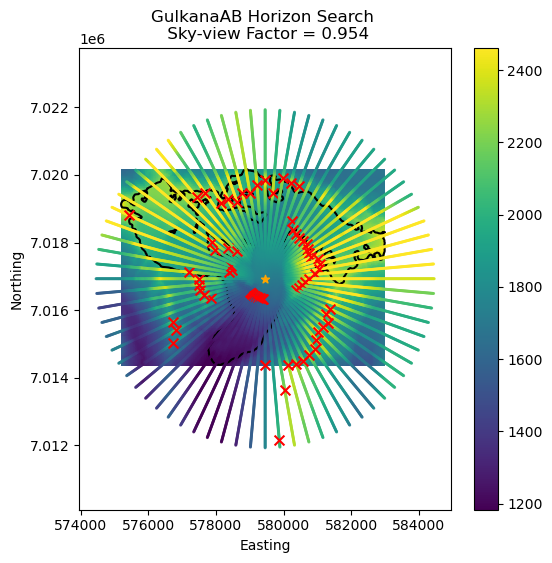

In [137]:
# =================== MODEL RUN ===================
# plot DEM as background
if plot_horizon:
    fig,ax = plt.subplots(figsize=(6,6))
    dem.plot(ax=ax,cmap='viridis')
    shapefile.plot(ax=ax,color='none',edgecolor='black',linewidth=1.5)
    plt.axis('equal')

# loop through angles
angles = np.arange(0,360,angle_step)
horizons = {}
for ang in angles:
    # set up dict to store
    horizons[ang] = {'horizon_elev':[],'hz_x':[],'hz_y':[],'xs':[],'ys':[]}
    
    # get line in the direction of choice
    xs, ys = select_coordinates(ang,dem_res,search_length)
    
    # select elevation gridcells along the line
    x_select = xr.DataArray(xs,dims=['location'])
    y_select = xr.DataArray(ys,dims=['location'])
    elev = dem.sel(x=x_select,y=y_select,method='nearest').values

    # filter out nans
    xs = xs[~np.isnan(elev)]
    ys = ys[~np.isnan(elev)]
    elev = elev[~np.isnan(elev)]
    
    # find the horizon
    hz_ang,hz_x,hz_y,all_angles = find_horizon(elev,xs,ys)
    horizons[ang]['horizon_elev'] = hz_ang
    horizons[ang]['hz_x'] = hz_x
    horizons[ang]['hz_y'] = hz_y
    horizons[ang]['xs'] = xs
    horizons[ang]['ys'] = ys

    # visualize elevations 
    if plot_horizon:
        norm = mpl.colors.Normalize(vmin=min_elev,vmax=max_elev)
        cmap = plt.cm.viridis
        scalar_map = mpl.cm.ScalarMappable(norm=norm,cmap=cmap)
        colors = scalar_map.to_rgba(elev)
        plt.scatter(xs,ys,color=colors,s=5,marker='.',alpha=0.8)
        plt.scatter(hz_x,hz_y,color='red',marker='x',s=50)

# calculate sky-view factor
horizon_elev = np.array([horizons[ang]['horizon_elev'] for ang in angles])
angle_step_rad = angle_step * pi/180
sky_view = np.sum(cos(horizon_elev)**2 * angle_step_rad) / (2*pi)

# scatter center point and plot
if plot_horizon:
    plt.scatter(xx,yy,marker='*',color='orange')
    plt.title(f'{site_name} Horizon Search \n Sky-view Factor = {sky_view:.3f}')
    plt.ylabel('Northing')
    plt.xlabel('Easting')
    if store_plot_horizon:
        plt.savefig(out_horizon_fp)
    else:
        plt.show()

In [138]:
# angle_to_vis = 180
# xs = horizons[angle_to_vis]['xs']
# ys = horizons[angle_to_vis]['ys']
# distances = np.sqrt((xs-xx)**2+(ys-yy)**2)
# fig_,ax_ = plt.subplots(2,sharex=True)
# ax_[0].plot(distances,horizons[angle_to_vis]['elang_arr']*180/pi)
# ax_[1].plot(distances,horizons[angle_to_vis]['elev_arr'])
# ax_[0].set_ylabel('Elevation Angle ($^\circ$)')
# ax_[1].set_ylabel('Elevation (m)')
# ax_[1].set_xlabel('Distance from point (m)')
# fig_.suptitle('Elevation and elevation angle along a line')
# plt.show()

### Testing: run a single point at a prescribed solar angle

In [140]:
all_az = np.arange(0,360,10) * pi/180
# all_elev = np.arange(0,60,2) * pi/180
all_elev = np.array([10])*pi/180
shade_list = []
for sun_az in all_az:
    for sun_elev in all_elev:
        # get nearest angle of horizon calculations to the sun azimuth
        sun_az = 2*pi + sun_az if sun_az < 0 else sun_az
        idx = np.argmin(np.abs(angles*pi/180 - sun_az))

        # check if the sun elevation angle is below the horizon angle
        if sun_elev < horizon_elev[idx]:
            shaded = 1  # shaded
        else:
            shaded = 0  # not shaded
        shade_list.append(shaded)
shade_arr = np.array(shade_list)
# vardata = shade_arr.reshape((len(all_az),len(all_elev)))
# fig,ax = plt.subplots()
# pc = ax.pcolormesh(all_az*180/pi,all_elev*180/pi,vardata.T, cmap='binary')
# ax.set_xlabel('Azimuth')
# ax.set_ylabel('Elevation')
# fig.suptitle(site_name)

## For model runs, generate a file of clear-sky slope-corrected direct irradiance for every hour of the year

In [91]:
# loop through hours of the year and store data
store_vars = ['dirirr','dirirrslope','shaded','sun_elev','horizon_elev','sun_az']
year_hours = pd.date_range('2024-01-01 00:00','2024-12-31 23:00',freq='h')
df = pd.DataFrame(data = np.ones((8784,len(store_vars))),
                  columns=store_vars,index=year_hours)
for time in year_hours:
    # calculate time-dependent variables
    time_UTC = time - timezone
    P = pressure(point_elev)
    r = r_sun(time)
    Z = zenith(time)
    d = declination(time)
    h = hour_angle(time)

    # calculate direct clear-sky irradiance (not slope corrected)
    I = I0 * (r_m/r)**2 * PSI**(P/P0/np.cos(Z)) * np.cos(Z)

    # get sun elevation and azimuth angle
    sunpos = suncalc.get_position(time_UTC,lon,lat)
    sun_elev = sunpos['altitude']       # solar elevation angle
    # suncalc gives azimuth with 0 = South, we want 0 = North
    sun_az = sunpos['azimuth'] + pi     # solar azimuth angle

    # incident angle calculation
    cosTHETA = cos(slp)*cos(Z) + sin(slp)*sin(Z)*cos(sun_az - asp)
    Islope = I*cosTHETA/cos(Z)
    Islope = max(0,Islope)

    # get nearest angle of horizon calculations to the sun azimuth
    sun_az = 2*pi + sun_az if sun_az < 0 else sun_az
    idx = np.argmin(np.abs(angles*pi/180 - sun_az))
    
    # check if the sun elevation angle is below the horizon angle
    if sun_elev < horizon_elev[idx]:
        shaded = 1  # shaded
    else:
        shaded = 0  # not shaded
    
    df.loc[time,'sun_az'] = sun_az * 180/pi
    df.loc[time,'horizon_elev'] = horizon_elev[idx] * 180/pi
    df.loc[time,'sun_elev'] = sun_elev * 180/pi
    df.loc[time,'shaded'] = shaded
    df.loc[time,'dirirrslope'] = Islope
    df.loc[time,'dirirr'] = I

2.0

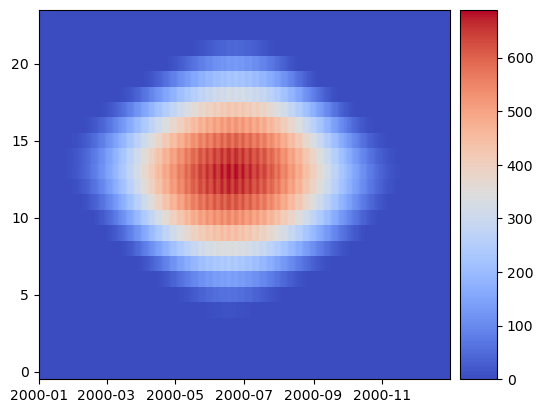

In [89]:
days = pd.date_range('2000-01-01 00:00','2000-12-31 23:00',freq='d')
hours = np.arange(0,24)
vardata = df['dirirr'].to_numpy().reshape((len(days),24))

fig,ax = plt.subplots()
pc = ax.pcolormesh(days,hours,vardata.T, cmap='coolwarm')
# ticks = np.linspace(np.ceil(np.min(vardata)),np.floor(np.max(vardata)),3)
# if ticks[1]%1 > 0:
#     ticks =  np.linspace(np.ceil(np.min(vardata)),np.floor(np.max(vardata))+1,3)
clb = fig.colorbar(pc,ax=ax,aspect=10,pad=0.02)

In [64]:
altitude_angle = suncalc.get_position(time,lon,lat)['altitude']
zenith = 180/np.pi * (np.pi/2 - altitude_angle) if altitude_angle > 0 else 89

In [73]:
time_UTC = pd.date_range('2023-06-01 00:00','2023-06-01 23:00',freq='h')
sunpos = suncalc.get_position(time_UTC,lon,lat)
sun_az = sunpos['azimuth'] + pi
print(sun_az)

Index([  3.948828704982952,   4.239564312210449,     4.5001526770687,
         4.739901064219209,   4.967818735381879,   5.191327676393756,
         5.416001390640519,   5.645437203053167,   5.881045671521058,
         6.121939443001479, 0.08209945541366626,  0.3241351632944962,
        0.5615895492709306,  0.7928807326427383,  1.0186782664470075,
        1.2419002503780447,  1.4675025849697316,  1.7023293849684573,
        1.9549625789010843,  2.2349357511302084,  2.5498046406898114,
         2.898586807263757,  3.2650739860701297,  3.6223132456257683],
      dtype='float64')
